In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam

from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

import lib.features as features
import lib.breeds as breeds
import lib.plots as plots
import lib.models as models

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
data_folder = '../data/csv/'

# get one mouse from each line
mice = [breeds.mice_breeds[line][0] for line in breeds.mice_breeds.keys()][:15] # get 15 mice from different lines
print(f"mice: {mice}")

data_files = [mouse + ".smo.csv" for mouse in mice]
data_files_train = data_files[:-1]
data_files_test = data_files[-1:]

print(f"Training on {data_files_train}")
print(f"Testing on {data_files_test}")

days = [0, 1, 2, 3]
window_sizes = [2, 5, 10, 20, 50, 100]
window_features = ["EEGv", "EMGv"]
spectral=True
rolloffs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
useRaw = False
dropBins = True
cat_matrix = True # True for neural net, any for random forest
standardize_df = False
test_size = 0.3

lr=1e-4
epochs=150
batch_size=64

seed = 13

mice: ['BL601', '1D203', 'BDF02', 'DBF01', '00501', '02901', '29T01', '03201', '04304', '04402', '04501', '04801', '04901', '05001', '05101']
Training on ['BL601.smo.csv', '1D203.smo.csv', 'BDF02.smo.csv', 'DBF01.smo.csv', '00501.smo.csv', '02901.smo.csv', '29T01.smo.csv', '03201.smo.csv', '04304.smo.csv', '04402.smo.csv', '04501.smo.csv', '04801.smo.csv', '04901.smo.csv', '05001.smo.csv']
Testing on ['05101.smo.csv']


In [3]:
# train and test on same mice
df_train = features.clean_data(
    data_folder=data_folder, 
    data_files=data_files_train,
    days=days, 
    window_sizes=window_sizes, 
    window_features=window_features,
    spectral=spectral,
    rolloffs=rolloffs,
    dropBins=dropBins, 
    useRaw=useRaw, 
    balance=True, 
    standardize_df=standardize_df,
    seed=seed,
)

df_test = features.clean_data(
    data_folder=data_folder, 
    data_files=data_files_test,
    days=days, 
    window_sizes=window_sizes, 
    window_features=window_features,
    spectral=spectral,
    rolloffs=rolloffs,
    dropBins=dropBins, 
    useRaw=useRaw, 
    balance=False, 
    standardize_df=standardize_df,
    seed=seed,
)

x_train, x_test, y_train, y_test, le = features.encode_scale_data(df_train=df_train, df_test=df_test, useRaw=useRaw, seed=seed, cat_matrix=cat_matrix)

c:\Users\matt989253\anaconda3\envs\temp2pip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\matt989253\anaconda3\envs\temp2pip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\matt989253\anaconda3\envs\temp2pip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Neural Network

In [4]:
model = models.nn_baseline_model(x_train.shape[1], le.classes_.size, lr=lr)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 246       
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
Total params: 258
Trainable params: 258
Non-trainable params: 0
_________________________________________________________________


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

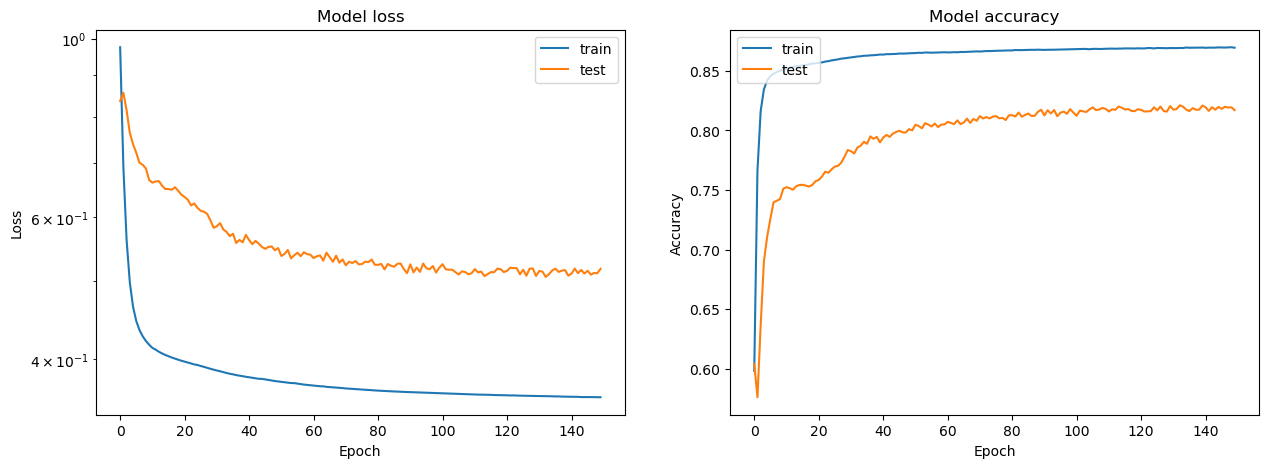

In [8]:
model = models.nn_baseline_model(x_train.shape[1], le.classes_.size, lr=lr)
history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_test, y_test),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=0,
                    callbacks=[TqdmCallback(verbose=1)]
                )

plots.plot_history(history.history)

1488/1488 [==============================] - 1s 610us/step
[[16567  5245   632]
 [    7  2148     4]
 [  341  2478 20166]]
              precision    recall  f1-score   support

           n       0.98      0.74      0.84     22444
           r       0.22      0.99      0.36      2159
           w       0.97      0.88      0.92     22985

    accuracy                           0.82     47588
   macro avg       0.72      0.87      0.71     47588
weighted avg       0.94      0.82      0.86     47588



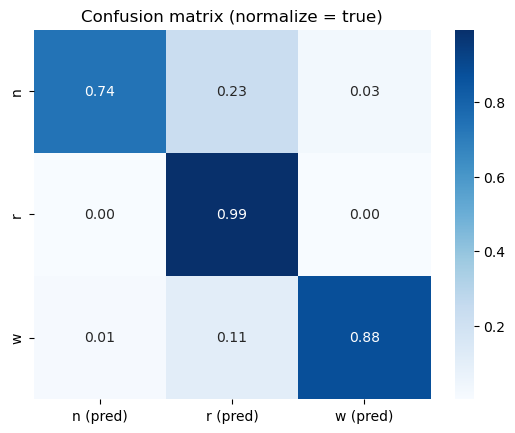

In [9]:
plots.plot_confusion(model=model, x_test=x_test, y_test=y_test, le=le, cat_matrix=True, normalize='true')

# Random Forest

[[18237  3547   660]
 [    7  2151     1]
 [  442  1382 21161]]
              precision    recall  f1-score   support

           n       0.98      0.81      0.89     22444
           r       0.30      1.00      0.47      2159
           w       0.97      0.92      0.94     22985

    accuracy                           0.87     47588
   macro avg       0.75      0.91      0.77     47588
weighted avg       0.94      0.87      0.90     47588



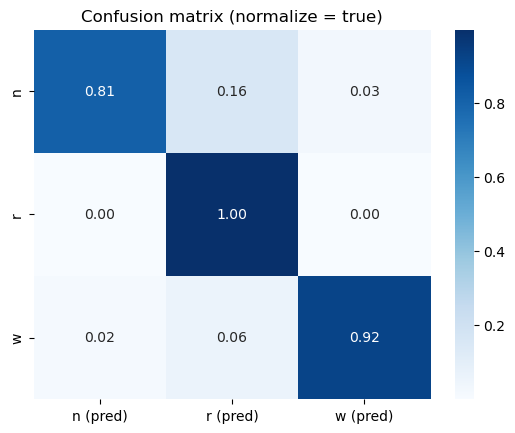

In [7]:
rfc = RandomForestClassifier(random_state=seed)
rfc.fit(x_train, y_train)
y_predict = rfc.predict(x_test)
plots.plot_confusion(model=rfc, x_test=x_test, y_test=y_test, le=le, cat_matrix=cat_matrix, normalize='true')